In [83]:
import json

import scipy.sparse as sps
import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv
import numpy as np
import pandas as pd

import scipy.stats as ss

from collections import namedtuple, defaultdict
from jproperties import Properties
from matplotlib import pyplot as plt

import tqdm
import json
import optuna
import tensorboardX as tb

In [122]:
configs = Properties()
with open('DIRECTORIES.properties', 'rb') as config_file:
    configs.load(config_file)

DATA_DIR = configs.get("DATA_DIR").data
LOG_DIR = configs.get("LOG_DIR").data
TENSORBOARD_DIR = configs.get("TENSORBOARD_DIR").data

In [123]:
all_tracks = pd.read_json(DATA_DIR + "tracks.json", lines=True)
all_tracks

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4
...,...,...,...
49995,Alain Bashung,Osez Joséphine,49995
49996,Habib Koité,Kanawa,49996
49997,De Saloon,Morder,49997
49998,She Wants Revenge,Red Flags And Long Nights,49998


In [124]:
user_items_interaction = pd.concat([
    pd.read_json(LOG_DIR + "data.json", lines=True)
]).drop_duplicates(subset=["user", "track"])

user_items_interaction.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2022-03-20 19:29:36.765,3255,2659,1.0,0.001031,177.0,"{'AA': 'C', 'INDEXED': 'C'}"
1,next,2022-03-20 19:29:36.780,3255,177,1.0,0.000906,1498.0,"{'AA': 'C', 'INDEXED': 'C'}"
2,next,2022-03-20 19:29:36.795,3255,1498,1.0,0.000867,1083.0,"{'AA': 'C', 'INDEXED': 'C'}"
3,next,2022-03-20 19:29:36.808,3255,1083,1.0,0.000939,188.0,"{'AA': 'C', 'INDEXED': 'C'}"
4,next,2022-03-20 19:29:36.818,3255,188,1.0,0.000883,188.0,"{'AA': 'C', 'INDEXED': 'C'}"


In [125]:
user_items_interaction.describe()

,user,track,time,latency,recommendation
count,350558.000000,350558.000000,350558.000000,350558.000000,310397.000000
mean,4980.452188,8084.212376,0.404384,0.006294,7356.094202
std,2882.918341,9994.227009,0.439652,3.038789,9398.987609
min,0.000000,6.000000,0.000000,-0.033951,7.000000
25%,2492.000000,1259.000000,0.000000,0.000862,1123.000000
50%,4968.000000,3819.000000,0.130000,0.000960,3300.000000
75%,7469.000000,11468.000000,0.980000,0.001107,10328.000000
max,9999.000000,49999.000000,1.000000,1799.203959,49959.000000


# Compute the most popular tracks
### popular = max(all_time)
##### Will use in TopPop recommender
###### Based on seminar 3

In [126]:
popular_tracks = (
    user_items_interaction
        .groupby("track")
        .sum()
        .sort_values("time", ascending=False)
        .reset_index()
)

popular_tracks

,track,user,time,latency,recommendation
0,177,6247302,602.47,1.416142,4225149.0
1,176,6028599,586.84,1.235918,4078968.0
2,424,5849515,580.60,1.318121,3863574.0
3,171,5913588,580.45,1.400788,3882243.0
4,170,6044179,563.47,1.354466,3716617.0
...,...,...,...,...,...
15842,1378,3825,0.00,0.001156,10814.0
15843,23887,7669,0.00,0.001785,782.0
15844,48503,1498,0.00,0.001238,18347.0
15845,29683,5716,0.00,0.000202,0.0


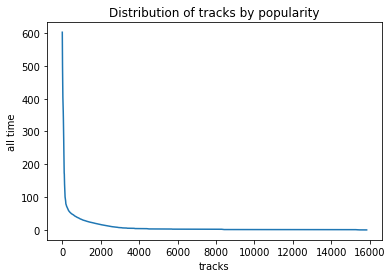

In [127]:
plt.plot(popular_tracks.index.values, popular_tracks["time"].values)
plt.xlabel("tracks")
plt.ylabel("all time")
plt.title("Distribution of tracks by popularity")
plt.show()

In [128]:
popular_tracks = popular_tracks[:20]
print(f'Count of popular tracks: {len(popular_tracks)}')

with open(DATA_DIR + "top_tracks.json", "w") as top_tracks_file:
    json.dump(popular_tracks["track"].tolist(), top_tracks_file)

Count of popular tracks: 20


# Compute user -> [firsts tracks], [favorites_tracks], [unfavorites_tracks],
# [favorites_artists], [unfavorites_artists]
##### Will use in SimilarUsers recommender

In [129]:
count_of_favorites = 3
liked = 0.8
unliked = 0.3

Pair = namedtuple("session",
                  ["user", "firsts", "favorites_tracks", "unfavorites_tracks",
                   "favorites_artists", "unfavorites_artists"])


def get_pairs(user_data):
    cur_user = None
    cur_first = None
    firsts = []
    favorites_tracks = []
    unfavorites_tracks = []
    favorites_artists = dict()
    unfavorites_artists = dict()

    for _, cur_row in user_data.sort_values("timestamp").iterrows():
        cur_track = cur_row["track"]
        cur_artist = all_tracks.loc[all_tracks.track == cur_track]["artist"].to_string(index=False)
        cur_user = cur_row["user"]
        if cur_first is None:
            cur_first = cur_track
            firsts.append(cur_first)
        if cur_row["message"] == "last":
            cur_first = None

        if cur_row["time"] >= liked:
            favorites_tracks.append((cur_track, cur_row["time"]))
            favorites_artists[cur_artist] = favorites_artists.get(cur_artist, 0) + 1
        elif cur_row["time"] <= unliked:
            unfavorites_tracks.append((cur_row["track"], cur_row["time"]))
            unfavorites_artists[cur_artist] = unfavorites_artists.get(cur_artist, 0) + 1

    favorites_tracks = set([i[0] for i in favorites_tracks])
    favorites_tracks = sorted(favorites_tracks, reverse=True)[:count_of_favorites]
    favorites_artists = list(dict(sorted(favorites_artists.items(), key=lambda item: item[1], reverse=True)).keys())[
                        :count_of_favorites]

    unfavorites_tracks = set([i[0] for i in unfavorites_tracks])
    unfavorites_artists = list(dict(sorted(unfavorites_artists.items(), key=lambda item: item[1])).keys())[
                          :count_of_favorites]
    return Pair(cur_user, set(firsts),
                set(favorites_tracks), set(unfavorites_tracks),
                set(favorites_artists), set(unfavorites_artists))


In [130]:
users_descriptions = pd.DataFrame(
    user_items_interaction
        .groupby("user")
        .apply(get_pairs)
        .values
        .tolist(),
    columns=["user", "firsts",
             "favorites_tracks", "unfavorites_tracks",
             "favorites_artists", "unfavorites_artists"]
)
users_descriptions.head()

,user,firsts,favorites_tracks,unfavorites_tracks,favorites_artists,unfavorites_artists
0,0,"{19498, 6022}","{19498, 6022}","{9701, 9125, 40936, 27850, 16686, 814, 49750, ...","{Lil Wayne / Bobby Valentino / Kidd Kidd, Slayer}","{Pavement, Killswitch Engage, Keyshia Cole}"
1,1,"{13026, 20938, 1262, 5308, 2175}","{20938, 14970, 13026}","{5890, 11461, 5382, 25545, 26636, 5198, 2257, ...","{Sheena Easton, Future Rock, Musiq}","{Cake, Maria Gadú, Skillet}"
2,2,"{6216, 744, 470, 758}","{6216, 3755, 4205}","{13152, 2795, 171, 2000, 176, 1490, 1499, 409,...","{Kanye West / Jay-Z, Coldplay, Four Tet}","{Muse, Emmy The Great, Justin Bieber / Jessica..."
3,3,"{8320, 22369, 2984, 2996, 1493, 155}","{22369, 15990, 8855}","{12289, 770, 2497, 21253, 12423, 2761, 12874, ...","{Nickelback, Portishead, 3 Doors Down}","{Enya, LL Cool J, Ace of Base}"
4,4,"{769, 42115, 15081, 16333, 13501, 2559}","{42115, 15084, 16333}","{769, 2939, 1541, 1544, 2251, 2254, 2000, 1490...","{Fun Lovin' Criminals, Two Door Cinema Club, G...","{Lady GaGa / Colby O'Donis, Masta Killa, Starf..."


In [131]:
with open(DATA_DIR + "users_firsts_favorites_unfavorites.json", "w") as rf:
    for _, user in tqdm.tqdm(users_descriptions.iterrows()):
        info = {
            "user": int(user["user"]),
            "firsts_tracks": [int(x) for x in user["firsts"]],
            "favorites_tracks": [int(x) for x in user["favorites_tracks"]],
            "unfavorites_tracks": [int(x) for x in user["unfavorites_tracks"]],
            "favorites_artists": [str(x) for x in user["favorites_artists"]],
            "unfavorites_artists": [str(x) for x in user["unfavorites_artists"]],
        }
        rf.write(json.dumps(info) + "\n")

9953it [00:01, 5019.57it/s]


In [13]:
# for idea with users embeddings

# users_descriptions_columns = pd.concat([
#     users_descriptions.user,
#     pd.DataFrame(users_descriptions.favorites_tracks.tolist(), columns=['ft_1', 'ft_2', 'ft_3']),
#     pd.DataFrame(users_descriptions.unfavorites_tracks.tolist(), columns=['uft_1', 'uft_2', 'uft_3']),
#     users_descriptions.favorites_artists,
#     users_descriptions.unfavorites_artists
# ], axis=1)
# users_descriptions_columns

In [23]:
# for idea with users embeddings

# users_descriptions_detailed = pd.get_dummies(users_descriptions_columns, columns=[
#     'ft_1', 'ft_2', 'ft_3',
#     'uft_1', 'uft_2', 'uft_3'
# ])
# users_descriptions_detailed.head(1)

# Compute similar tracks to create recommendations for each track
##### Will use in ContextualByFirst recommender
# Compute similar users
##### Will use in SimilarUsers recommender
###### Based on seminar 5

In [14]:
positives = user_items_interaction[user_items_interaction["time"] > liked].copy()
positives.drop(columns=["message", "timestamp", "latency", "recommendation", "experiments"], inplace=True)
positives["test"] = np.random.random(len(positives)) >= 0.7
positives

,user,track,time,test
0,3392,2142,1.00,False
4,3392,20975,0.94,False
7,379,9551,1.00,False
14,5884,48370,1.00,True
21,181,24587,1.00,False
...,...,...,...,...
355200,8221,21258,0.92,False
355203,9604,6903,1.00,True
355209,7235,5456,1.00,False
355211,7235,31231,0.98,False


In [15]:
count_const = 5
user_counts = positives.groupby("user").size()
users = set(user_counts[user_counts >= count_const].index.values)

In [16]:
track_counts = positives.groupby("track").size()
tracks = set(track_counts[track_counts >= count_const].index.values)

In [17]:
len(users), len(tracks)

(7056, 3297)

In [18]:
# train LightFM
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
all_data = positives[positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data), len(all_data)

(19112, 8140, 27252)

In [ ]:
# for idea with users embeddings

# users_features_cols = users_descriptions_detailed.columns.values.tolist()
# users_features_cols.remove('user')
# users_features = []
# for _, row in users_descriptions_detailed.iterrows():
#     if row['user'] in users:
#         users_features.append((int(row['user']), row[users_features_cols].to_dict()))
# users_features[0]

In [19]:
dataset = ld.Dataset()
# for idea with users embeddings
# dataset.fit(users, tracks, user_features=users_features_cols)
dataset.fit(users, tracks)

In [ ]:
# users_features_matrix = dataset.build_user_features(users_features)

In [20]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))
data_interactions, _ = dataset.build_interactions(all_data[["user", "track"]].itertuples(index=False, name=None))

In [21]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0,
              item_alpha=0.0, threads=30, verbose=False):
    model_fm = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at_fm = []

    for epoch in range(epochs):
        model_fm = model_fm.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model_fm, test_interactions, train_interactions=train_interactions, k=at,
                                         num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at_fm.append(np.mean(precision_at))

    return model_fm, precisions_at_fm


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])

    model_fm, precisions_at_fm = fit_model(
        epochs=5,
        at=10,
        loss=loss,
        no_components=no_components,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    return precisions_at_fm[-1]

In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

# best_params = {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0001}

[I 2022-04-06 13:50:16,919] A new study created in memory with name: no-name-8cbd2b64-00b5-481b-a59b-032a566fdc68
[I 2022-04-06 13:50:37,601] Trial 0 finished with value: 0.00041955107008107007 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.00041955107008107007.
[I 2022-04-06 13:50:46,147] Trial 1 finished with value: 0.005034612957388163 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.005034612957388163.
[I 2022-04-06 13:51:09,677] Trial 2 finished with value: 0.0003775959776248783 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.005034612957388163.
[I 2022-04-06 13:51:29,217] Trial 3 finished with value: 0.0010488777188584208 a

In [23]:
best_params

{'loss': 'warp',
 'no_components': 10,
 'learning_rate': 0.001,
 'max_sampled': 100,
 'user_alpha': 0.0001,
 'item_alpha': 0.0001}

In [24]:
model = lightfm.LightFM(
    no_components=best_params["no_components"],
    loss=best_params["loss"],
    learning_rate=best_params["learning_rate"],
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
)
model = model.fit_partial(data_interactions, num_threads=30, epochs=200)

In [25]:
items_embeddings = (model.item_embeddings.T
                      / np.linalg.norm(model.item_embeddings, axis=1)).T

users_embeddings = (model.user_embeddings.T
                      / np.linalg.norm(model.user_embeddings, axis=1)).T

In [26]:
user_meta = pd.DataFrame(data=users, columns=['user'])
user_meta

,user
0,1
1,2
2,3
3,4
4,6
...,...
7051,9992
7052,9994
7053,9995
7054,9996


In [27]:
all_tracks["dataset_index"] = all_tracks["track"].map(lambda t: dataset.mapping()[2].get(t))
user_meta["dataset_index"] = user_meta["user"].map(lambda t: dataset.mapping()[0].get(t))

In [28]:
dataset_tracks = all_tracks[pd.notnull(all_tracks["dataset_index"])].sort_values("dataset_index")
dataset_users = user_meta[pd.notnull(user_meta["dataset_index"])].sort_values("dataset_index")
len(dataset_tracks), len(dataset_users)

(3297, 7056)

In [29]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=TENSORBOARD_DIR)
writer.add_embedding(items_embeddings,
                     metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)),
                     tag="lightfm", metadata_header=["artist", "title"])
writer.close()

In [30]:
k = 20
max_tracks_from_same_artist = 10

with open(DATA_DIR + f"recommendations_tracks_{k}_{max_tracks_from_same_artist}.json", "w") as rf:
    for _, track in tqdm.tqdm(all_tracks.iterrows()):
        j = track["dataset_index"]

        recommendations = []
        if pd.notna(j):
            embedding = items_embeddings[int(j)]
            neighbours = np.argsort(-np.dot(items_embeddings, embedding))

            artists = defaultdict(int)
            for neighbour in neighbours:
                recommended_track = dataset_tracks[dataset_tracks["dataset_index"] == neighbour].iloc[0]

                recommendation = int(recommended_track["track"])
                if recommendation == track["track"]:
                    continue

                artist = recommended_track["artist"]
                if artists[artist] >= max_tracks_from_same_artist:
                    continue

                recommendations.append(recommendation)
                artists[artist] += 1

                if len(recommendations) == k:
                    break

        track_with_recommendations = dict(track)
        track_with_recommendations["recommendations"] = recommendations

        rf.write(json.dumps(track_with_recommendations) + "\n")

50000it [01:15, 666.06it/s] 


In [77]:
count_similar_users = 5
with open(DATA_DIR + f"similar_users_{count_similar_users}.json", "w") as rf:
    for _, user in tqdm.tqdm(user_meta.iterrows()):
        j = user["dataset_index"]

        similar = []
        if pd.notna(j):
            embedding = users_embeddings[int(j)]
            neighbours = np.argsort(-np.dot(users_embeddings, embedding))

            for neighbour in neighbours:
                recommended_user = dataset_users[dataset_users["dataset_index"] == neighbour].iloc[0]

                recommendation = int(recommended_user["user"])
                if recommendation == user["user"]:
                    continue

                similar.append(recommendation)

                if len(similar) == count_similar_users:
                    break

        user_with_similar = dict()
        user_with_similar["user"] = int(user["user"])
        user_with_similar["similar"] = similar

        rf.write(json.dumps(user_with_similar) + "\n")

7056it [00:58, 120.41it/s]


In [66]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [75]:
int_users_to_ext_users = {v: k for k, v in dataset.mapping()[0].items()}
ext_users_to_int_users = dataset.mapping()[0]

int_items_to_ext_items = {v: k for k, v in dataset.mapping()[2].items()}
ext_items_to_int_items = dataset.mapping()[2]

In [76]:
with open(DATA_DIR + "recommendations_users.json", "w") as rf:
    for user_index in tqdm.tqdm(int_users_to_ext_users.keys()):
        predictions = model.predict(user_index, list(int_items_to_ext_items.keys()), num_threads=30)
        top = [list(int_items_to_ext_items.keys())[x] for x in np.argsort(predictions)[-20:]]
        recommendation = {
            "user": int(int_users_to_ext_users.get(user_index)),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 7056/7056 [00:19<00:00, 369.93it/s]
